In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Find the most recent date in the data set.
date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(date)

('2017-08-23',)


2016-08-23


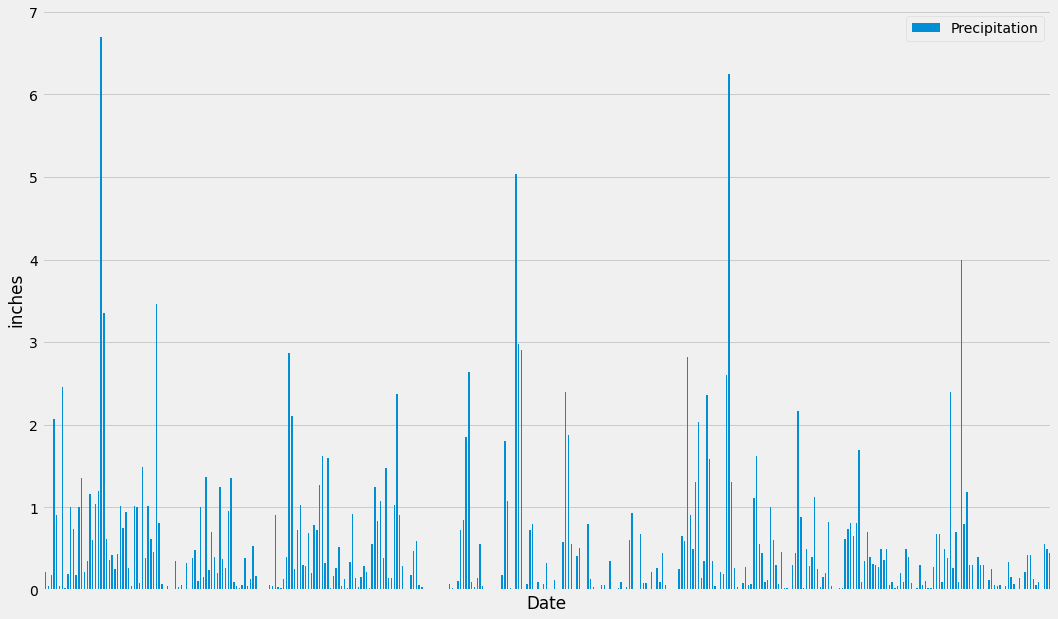

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 


# Calculate the date one year from the last date in data set.
qdate = dt.date(2017,8,23) - dt.timedelta(days=365)
print(qdate)

# Perform a query to retrieve the data and precipitation scores
prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > qdate).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(prcp).set_index('date')

# Sort the dataframe by date
df = df.rename(columns={'prcp':'Precipitation'}).groupby('date').max()
# Use Pandas Plotting with Matplotlib to plot the data
df.plot.bar(figsize=(15,10))
plt.xlabel('Date')
plt.ylabel('inches')
plt.tight_layout()
plt.xticks([])
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,365.000000
mean,0.517288
std,0.829196
min,0.000000
25%,0.040000
50%,0.250000
75%,0.650000
max,6.700000


# Exploratory Station Analysis

In [13]:
col = inspector.get_columns('station')
for c in col:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
# Design a query to calculate the total number stations in the dataset
number = session.query(Station.name).count()
number

9

In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
records = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

for record in records:
    print(record)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
st1 = records[0][0]

low = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == st1).all()
avg = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == st1).all()
high = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station == st1).all()
name = session.query(Station.name).\
    filter(Station.station == st1).all()

print(f'The stations {name[0][0]} was the most active station.')
print(f'Its lowest temperature was {low[0][0]}, its mean was {round(avg[0][0],1)} and its highest was {high[0][0]}.')

The stations WAIHEE 837.5, HI US was the most active station.
Its lowest temperature was 54.0, its mean was 71.7 and its highest was 85.0.


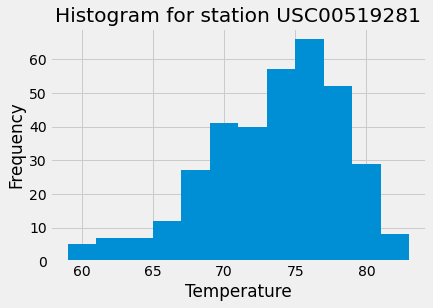

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

df1 = pd.DataFrame(session.query(Measurement.tobs).\
                  filter(Measurement.station == st1).\
                  filter(Measurement.date > qdate).all())
x = np.array(df1)
plt.hist(x, bins=12)
plt.title(f'Histogram for station {st1}')
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.show()

# Close session

In [18]:
# Close Session
session.close()